# Тестирование гипотез
------------------------------

## DEMOGRAPHICS гипотеза

H₀ (Нулевая гипотеза): Доля женщин (в процентах) в университетах не зависит от их размера. Средние доли (или медианы, для непараметрического теста) генеральной совокупности равны во всех категориях размера.

H₁ (Альтернативная гипотеза): Доля женщин (в процентах) в университетах зависит от их размера. Существует хотя бы одна пара категорий размера, между которыми средние доли (медианы) генеральной совокупности статистически значимо различаются.

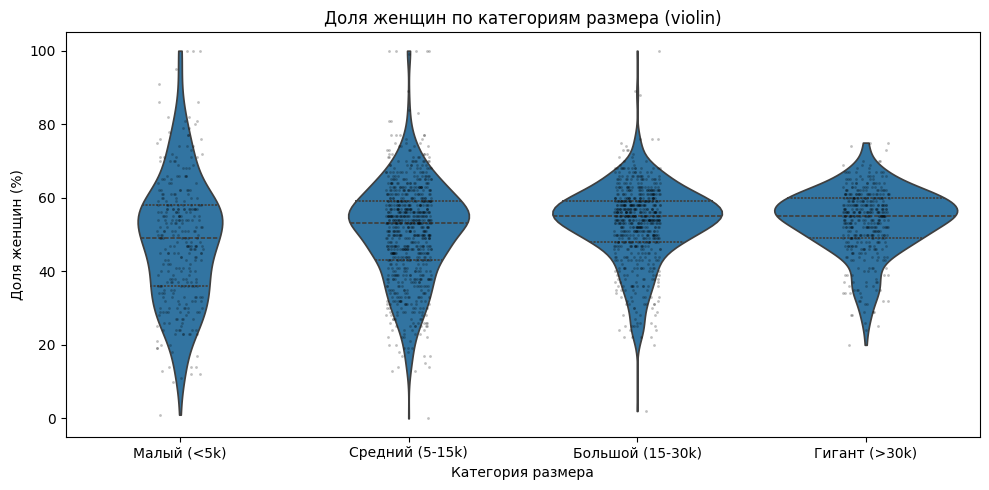

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('/Users/anastasiahimic/Desktop/hse_python_project_3/analytics/MAIN.csv')

df_size = df[['No. of FTE students', 'Female_share']].dropna()

df_size['Size_Category'] = pd.cut(
    df_size['No. of FTE students'],
    bins=[0, 5000, 15000, 30000, 1000000],
    labels=['Малый (<5k)', 'Средний (5-15k)', 'Большой (15-30k)', 'Гигант (>30k)']
)

plt.figure(figsize=(10,5))
sns.violinplot(data=df_size, x='Size_Category', y='Female_share', inner='quart', cut=0)
sns.stripplot(data=df_size, x='Size_Category', y='Female_share', color='black', alpha=0.25, size=2)
plt.xlabel('Категория размера')
plt.ylabel('Доля женщин (%)')
plt.title('Доля женщин по категориям размера (violin)')
plt.tight_layout()
plt.show()



In [22]:
import numpy as np
import pandas as pd
from scipy import stats

# группы
groups = [g['Female_share'].dropna().values
          for _, g in df_size.groupby('Size_Category')]

# 1) размеры групп
print(df_size['Size_Category'].value_counts(dropna=False))

# 2) Levene (равенство дисперсий)
lev_stat, lev_p = stats.levene(*groups, center='median')  # median часто устойчивее
print(f"Levene: stat={lev_stat:.3f}, p={lev_p:.4f}")


Size_Category
Средний (5-15k)     806
Большой (15-30k)    677
Гигант (>30k)       438
Малый (<5k)         314
Name: count, dtype: int64
Levene: stat=57.056, p=0.0000


/var/folders/xp/w27tw8rj1yq_fp98wz42_9q80000gn/T/ipykernel_14603/1142164882.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, g in df_size.groupby('Size_Category')]


Для проверки гипотезы о различиях доли женщин между четырьмя категориями размера вуза мы сначала равенство дисперсий внутри групп. Тест Левена показал статистически значимое различие дисперсий между группами (p < 0.001), следовательно, ключевая предпосылка классической ANOVA (гомогенность дисперсий) нарушена. При таких условиях применение обычной ANOVA может давать некорректные p-value, поэтому требуется более устойчивый подход (например, Welch ANOVA).

В связи с нарушением гомогенности дисперсий в качестве основного параметрического метода мы выбрали Welch ANOVA — это модификация однофакторного дисперсионного анализа, которая корректно работает при неравных дисперсиях и неодинаковых размерах групп, поэтому в наших данных она предпочтительнее классической ANOVA. Далее, поскольку Welch ANOVA показывает лишь факт наличия различий «хотя бы между какими‑то группами», для уточнения между какими именно категориями размера существуют статистически значимые различия был применён post-hoc тест Games–Howell. Этот post-hoc подход согласован с логикой Welch ANOVA и также рассчитан на ситуацию с неравными дисперсиями и разными объёмами выборок, поэтому он обеспечивает корректные парные сравнения без опоры на предпосылку равенства дисперсий.

### WelchANOVA  + Games–Howell

In [23]:
import pingouin as pg

# Welch ANOVA
welch = pg.welch_anova(data=df_size, dv='Female_share', between='Size_Category')
print("Welch ANOVA")
print(welch)

# Post-hoc Games–Howell
gh = pg.pairwise_gameshowell(data=df_size, dv='Female_share', between='Size_Category')
gh = gh.sort_values('pval')
print("\nGames–Howell post-hoc (sorted by p-value)")
print(gh)


Welch ANOVA
          Source  ddof1       ddof2          F         p-unc       np2
0  Size_Category      3  969.976466  12.800168  3.304864e-08  0.019542

Games–Howell post-hoc (sorted by p-value)
                  A                 B    mean(A)    mean(B)      diff  \
2       Малый (<5k)     Гигант (>30k)  48.238854  53.598174 -5.359320   
1       Малый (<5k)  Большой (15-30k)  48.238854  53.047267 -4.808414   
4   Средний (5-15k)     Гигант (>30k)  50.852357  53.598174 -2.745816   
3   Средний (5-15k)  Большой (15-30k)  50.852357  53.047267 -2.194910   
0       Малый (<5k)   Средний (5-15k)  48.238854  50.852357 -2.613504   
5  Большой (15-30k)     Гигант (>30k)  53.047267  53.598174 -0.550906   

         se         T           df      pval    hedges  
2  1.068721 -5.014706   436.235329  0.000005 -0.407060  
1  1.058548 -4.542463   425.535957  0.000043 -0.366634  
4  0.650623 -4.220289  1197.661701  0.000154 -0.222610  
3  0.633774 -3.463238  1470.204604  0.003079 -0.176484  
0  1.0

Source — фактор, который тестируешь: здесь Size_Category (категория размера вуза).

ddof1 — числитель степеней свободы (degrees of freedom 1): число уровней фактора − 1. У тебя 4 категории размера → 4−1 = 3.

ddof2 — знаменатель степеней свободы Welch ANOVA (эффективные df для ошибки, не обязательно целое число).

F — значение F‑статистики Welch ANOVA: отношение «межгрупповая вариация / внутригрупповая», с поправкой на неравные дисперсии и размеры. Чем больше F, тем сильнее различия средних.

p-unc — p‑value для F‑статистики без поправки на множественные сравнения. Очень маленькое (3.3e‑08) → средние между категориями размера существенно различаются.

np2 — частичный (eta squared), мера размера эффекта: какую долю дисперсии переменной объясняет фактор Size_Category. Значение ~0.02 = небольшой, но не нулевой эффект.

- **A, B** — какие именно группы сравниваем.  
  Например, *Малый (<5k)* vs *Гигант (>30k)*.

- **mean(A), mean(B)** — среднее значение изучаемого показателя (например, Teaching) в каждой группе.  
  Пример:  
  - `mean(A) = 48.24` — средний score у малых вузов.  
  - `mean(B) = 53.60` — у гигантов.

- **diff** — разница средних: `diff = mean(A) − mean(B)`.  
  Отрицательное число значит, что в группе A среднее ниже, чем в B.  
  Например, `−5.36` → малые вузы в среднем на 5.36 пункта ниже, чем гиганты.

- **se (standard error)** — стандартная ошибка оценки разницы средних в тесте Games–Howell.  
  Чем меньше `se`, тем точнее оценка разницы.

- **T** — t‑подобная статистика теста Games–Howell:  
  По модулю: чем больше `T`, тем сильнее отличия между группами.

- **df** — эффективные степени свободы для данного сравнения.  
  У Games–Howell они свои для каждой пары и могут быть нецелыми.

- **pval** — p‑value для проверки гипотез:  
  - \(H_0\): средние в группах A и B равны;  
  - \(H_1\): средние различаются.  
  Маленькое `pval` (например, `0.000005`) → различия средних статистически значимы.  
  Большое `pval` (например, `0.79`) → статистически значимых различий нет.

- **hedges** — Hedges’ g, мера *размера эффекта* (разница средних в единицах стандартного отклонения с поправкой на смещение).  
  - по модулю ~0.2 — маленький эффект;  
  - ~0.5 — средний;  
  - ≥0.8 — крупный.  
  Например, `−0.41` — умеренный отрицательный эффект: гиганты заметно сильнее малых по метрике.


### Вывод по гипотезе (Welch ANOVA + Games–Howell)

По Welch ANOVA доля женщин статистически значимо различается между категориями размера вузов: F = 12.80, p = 3.30 × 10^-8
, поэтому нулевая гипотеза о равенстве средних долей во всех группах отвергается. 

Post-hoc тест Games–Howell показывает, между какими именно категориями есть различия (смотрим пары с `pval < 0.05`) и в какую сторону (по знаку `diff = mean(A) - mean(B)`). 

**Значимые различия (p < 0.05):**
- В **гигантских** вузах доля женщин выше, чем в **малых** (≈ 5.36 п.п.; p=0.000005) и выше, чем в **средних** (≈ 2.75 п.п.; p=0.000154).
- В **больших** вузах доля женщин выше, чем в **малых** (≈ 4.81 п.п.; p=0.000043) и выше, чем в **средних** (≈ 2.19 п.п.; p=0.003079).

**Незначимые различия (p ≥ 0.05):**
- Между **большими** и **гигантскими** вузами различий не обнаружено (≈ 0.55 п.п.; p=0.791).
- Различие между **малыми** и **средними** не подтверждено на уровне 5% (≈ 2.61 п.п.; p=0.079). 

**Итог:** в более крупных вузах (≥15k студентов) доля женщин в среднем выше, чем в малых/средних, при этом между большими и гигантскими различий нет.


## ACADEMIC гипотеза

H₀ (Нулевая гипотеза): Доля вузов, где Research Quality заметно превышает Teaching, равна доле вузов, где Teaching заметно превышает Research Quality 

H₁ (Альтернативная гипотеза) - Исследовательская гипотеза: Доля вузов, где Research Quality заметно превышает Teaching, больше, чем доля вузов с обратной ситуацией.

После введения порога “заметного доминирования” (thr) каждый университет относится к одной из двух категорий:  
1) **RQ доминирует** (Research Quality − Teaching > thr) или  
2) **Teaching доминирует** (Teaching − Research Quality > thr).  
Университеты, где разница меньше порога, считаются “без явного доминирования” и не участвуют в проверке.

Таким образом, проверяется **одна пропорция**: доля университетов, где доминирует RQ, среди всех университетов с явным доминированием.  
Нулевая гипотеза “доли равны” эквивалентна **H₀: p = 0.5**, а исследовательская гипотеза задаёт направление **H₁: p > 0.5** (односторонняя проверка).

Поэтому используется **одновыборочный z‑тест для доли**: он сравнивает наблюдаемую долю с заданным значением (0.5) и позволяет задать одностороннюю альтернативу. При достаточно большом числе наблюдений нормальное приближение для доли корректно, поэтому тест применим для нашей выборки.

### Z‑тест

In [15]:
import numpy as np
from statsmodels.stats.proportion import proportions_ztest

# 1) порог "заметно"
thr = 20

# 2) считаем "доминирование"
rq_dom = (df['Research Quality'] - df['Teaching'] > thr)
t_dom  = (df['Teaching'] - df['Research Quality'] > thr)

# 3) оставляем только случаи, где доминирование есть (без "ничьи")
mask = rq_dom | t_dom

x = int(rq_dom[mask].sum())   # "успехи": RQ доминирует
n = int(mask.sum())           # всего наблюдений в тесте

# 4) z-тест: H0 p=0.5 vs H1 p>0.5
z_stat, p_one = proportions_ztest(count=x, nobs=n, value=0.5, alternative='larger')  # one-sided

print(f"threshold={thr}")
print(f"x={x}, n={n}, p_hat={x/n:.4f}")
print(f"z={z_stat:.4f}, p_one_sided={p_one:.6g}")


threshold=20
x=1203, n=1212, p_hat=0.9926
z=199.7430, p_one_sided=0


При пороге “заметного доминирования” thr = 20 доля вузов, где Research Quality значительно превышает Teaching, составила 99.26% (1203 из 1212). Одновыборочный z‑тест для пропорции (H0: p = 0.5 vs H1: p > 0.5) дал z = 199.74 и p < 0.001 (в вычислениях p округлилось до 0 из‑за крайне малого значения). Следовательно, нулевая гипотеза отвергается: доминирование Research Quality встречается существенно чаще, чем доминирование Teaching.

## ELITE гипотеза

H₀ (нулевая гипотеза): Связь между силой гуманитарного профиля и силой STEM-профиля одинакова у “средних” вузов и у элитных вузов (то есть статус “элитный” не меняет характер этой связи; эффекта различия нет).

H₁ (альтернативная гипотеза): У “средних” вузов связь между гуманитарным профилем и STEM-профилем отрицательная (чем сильнее гуманитарное, тем слабее STEM, и наоборот), а у элитных вузов эта отрицательная связь существенно слабее, отсутствует или становится положительной.


Мы хотим проверить не разницу средних, а отличается ли зависимость STEM от гуманитарного профиля у элитных и не‑элитных вузов.​
Для этого строим линейную регрессию S ~ H * elite: она фактически оценивает две прямые (одну для elite=0 и одну для elite=1) и проверяет, одинаковый ли у них наклон.
​
Коэффициент H:elite — это и есть тест гипотезы “у элиты связь другая”: если он значим, значит наклон (сила/направление связи) у элиты отличается от не‑элиты; если незначим — статистически отличий нет.
​
Запись H * elite в statsmodels — это сокращение для H + elite + H:elite (добавляем и сами переменные, и их взаимодействие).

In [19]:
import pandas as pd
import statsmodels.formula.api as smf

cols = ["Arts and Humanities 2025","Computer Science 2025","Engineering 2025",
        "Physical Sciences 2025","Overall_num"]
for c in cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df["H"] = df["Arts and Humanities 2025"]
df["S"] = df[["Computer Science 2025","Engineering 2025","Physical Sciences 2025"]].mean(axis=1)

# элита: порог 90
df["elite"] = (df["Overall_num"] >= 90).astype(int)

m = smf.ols("S ~ H * elite", data=df).fit()
print(m.summary())


                            OLS Regression Results                            
Dep. Variable:                      S   R-squared:                       0.626
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                     684.4
Date:                Sat, 20 Dec 2025   Prob (F-statistic):          2.63e-261
Time:                        02:48:42   Log-Likelihood:                -8133.7
No. Observations:                1230   AIC:                         1.628e+04
Df Residuals:                    1226   BIC:                         1.630e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     92.1289     10.783      8.544      0.0

Гипотеза про “trade-off у средних” не подтверждается: коэффициент при H положительный и статистически значимый (≈ 0.8845; p < 0.001), то есть у не‑элиты (elite=0) чем выше гуманитарный скор, тем в среднем выше STEM‑скор.

Гипотеза “у элиты связь другая” тоже не подтверждается: interaction H:elite незначим (p = 0.533), значит статистических оснований считать, что наклон связи Humanities→STEM у элиты отличается от не‑элиты, нет.

In [20]:
import numpy as np
import pandas as pd
from scipy import stats

# df должен содержать колонки: H, S, elite (0/1)
# elite=1 — элита (Overall_num >= 90), elite=0 — остальные

def fisher_r_to_z(r):
    # Fisher z-transform: z = 0.5 * ln((1+r)/(1-r))
    return 0.5 * np.log((1 + r) / (1 - r))

def compare_independent_corr(r1, n1, r2, n2, alternative="two-sided"):
    """
    Fisher r-to-z test for difference between two independent correlations.
    alternative: "two-sided", "greater" (r1 > r2), "less" (r1 < r2)
    """
    z1 = fisher_r_to_z(r1)
    z2 = fisher_r_to_z(r2)
    se = np.sqrt(1/(n1 - 3) + 1/(n2 - 3))
    z = (z1 - z2) / se

    if alternative == "two-sided":
        p = 2 * (1 - stats.norm.cdf(abs(z)))
    elif alternative == "greater":
        p = 1 - stats.norm.cdf(z)
    elif alternative == "less":
        p = stats.norm.cdf(z)
    else:
        raise ValueError("alternative must be: two-sided / greater / less")

    return z, p

# --- 1) Корреляции по группам ---
g0 = df[df["elite"] == 0][["H", "S"]].dropna()
g1 = df[df["elite"] == 1][["H", "S"]].dropna()

r0, p0 = stats.pearsonr(g0["H"], g0["S"])
r1, p1 = stats.pearsonr(g1["H"], g1["S"])

n0, n1 = len(g0), len(g1)

print(f"Non-elite: n={n0}, r={r0:.4f}, p={p0:.3g}")
print(f"Elite:     n={n1}, r={r1:.4f}, p={p1:.3g}")

# --- 2) Fisher r-to-z: отличаются ли корреляции ---
# H1: корреляция в элите != корреляции у не-элиты
z_stat, p_diff = compare_independent_corr(r1, n1, r0, n0, alternative="two-sided")

print(f"Fisher r-to-z test (elite vs non-elite): z={z_stat:.3f}, p={p_diff:.3g}")


Non-elite: n=1214, r=0.7823, p=2.13e-251
Elite:     n=16, r=0.4100, p=0.115
Fisher r-to-z test (elite vs non-elite): z=-2.208, p=0.0273


У не‑элитных вузов наблюдается сильная положительная связь между гуманитарным и STEM‑профилем (r = 0.782; p ≈ 2.1e‑251), тогда как у элиты (Overall ≥ 90) связь заметно слабее (r = 0.41; p = 0.115).

Тест Fisher r‑to‑z показывает, что корреляции между группами статистически различаются (z = −2.21; p = 0.027), то есть у элитных вузов взаимосвязь Humanities–STEM действительно слабее, чем у не‑элиты.

При этом вывод по элите нужно трактовать осторожно из‑за очень малого размера группы (n = 16): оценка корреляции нестабильна, поэтому стоит проверить устойчивость результата на другом определении “элиты” или с робастной корреляцией (Spearman).

Основной (модельный) тест через interaction в OLS не выявил различий наклона, однако альтернативная проверка через Fisher r‑to‑z показала значимое различие корреляций; учитывая малое число элитных вузов (n=16), вывод о различиях следует трактовать осторожно.